Dev notes: I directly installed the model en_core_web_sm 3.7.1 via 'uv add'.

In [1]:
from torchtext import data, datasets
import torch
import spacy
import random
import numpy as np

def set_seed(seed = 4002):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(4002)

In [2]:
# Load SpaCy
nlp = spacy.load("en_core_web_sm")

 # For tokenization
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm',include_lengths = True, pad_token='<pad>')
# For multi - class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data , test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained = False)
# Split train into train/valid (80/20)
train_data, valid_data = train_data.split(
    split_ratio=0.8,
    random_state=random.seed(42)  # <-- use random.seed here
)

print(f"Train examples: {len(train_data)}")
print(f"Validation examples: {len(valid_data)}")

Train examples: 4362
Validation examples: 1090


In [3]:
print(vars(train_data.examples[0]))

{'text': ['What', 'is', 'the', 'most', 'famous', 'German', 'word', 'in', 'the', 'English', 'language', '?'], 'label': 'ENTY'}


Let's use Glove model for word embeddings.     
(Start with GloVe 6B.100d or 6B.300d as it provides a good balance between coverage and performance for TREC's question classification task. If results are underwhelming, experiment with word2vec Google News vectors as an alternative, but empirical results in the literature suggest GloVe performs comparably or slightly better on this specific dataset.)

In [6]:
from torchtext.vocab import GloVe, Vectors

# Option 1: Use built-in GloVe (torchtext will download automatically)
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=100))

.vector_cache\glove.6B.zip: 862MB [07:00, 2.05MB/s]                                
100%|█████████▉| 399999/400000 [01:11<00:00, 5616.38it/s] 


In [7]:
LABEL.build_vocab(train_data)

# Qn 1: Word Embeddings
a) What is the size of the vocabulary formed from your training data according to your tokenization method?

In [8]:
# Get vocabulary size
vocab_size = len(TEXT.vocab)
print(f"Vocabulary size: {vocab_size}")
print("# of Labels: ", len(LABEL.vocab))  # number of distinct labels (topics)

Vocabulary size: 8093
# of Labels:  6


b) We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but
not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?
What is the number of OOV words for each topic category?

In [9]:
import torchtext
from collections import defaultdict, Counter
# Get only the GloVe vocab (words with pretrained vectors)
glove_vocab = set(torchtext.vocab.GloVe(name='6B', dim=100).stoi.keys())

oov_words_by_topic = defaultdict(Counter)

for example in train_data.examples:
    label = example.label
    tokens = example.text  # Already tokenized as list of tokens by spacy
    for token in tokens:
        # Lowercase token to match GloVe casing
        token_lower = token.lower()
        if token_lower not in glove_vocab:
            oov_words_by_topic[label][token_lower] += 1

total_oov_words = set()
for counter in oov_words_by_topic.values():
    total_oov_words.update(counter.keys())

total_count = sum(
    count
    for counter in oov_words_by_topic.values()
    for count in counter.values()
)
print(f"Total count of all OOV word occurrences: {total_count}")
print(f"Total number of OOV words in training data: {len(total_oov_words)}")
print("Number of OOV words per topic category:")

for topic, counter in oov_words_by_topic.items():
    print(f"Topic {topic}: {len(counter)} unique OOV words")
    print("Total occurrence of OOV words: ", sum(counter.values()))
    print("-"*50)


Total count of all OOV word occurrences: 202
Total number of OOV words in training data: 190
Number of OOV words per topic category:
Topic DESC: 68 unique OOV words
Total occurrence of OOV words:  69
--------------------------------------------------
Topic ENTY: 47 unique OOV words
Total occurrence of OOV words:  52
--------------------------------------------------
Topic HUM: 39 unique OOV words
Total occurrence of OOV words:  40
--------------------------------------------------
Topic ABBR: 4 unique OOV words
Total occurrence of OOV words:  4
--------------------------------------------------
Topic NUM: 21 unique OOV words
Total occurrence of OOV words:  21
--------------------------------------------------
Topic LOC: 15 unique OOV words
Total occurrence of OOV words:  16
--------------------------------------------------


(c) The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove).
Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you
think is the best strategy to mitigate such limitation? Implement your solution in your source
code. Show the corresponding code snippet

One way to mitigate the problem of OOV words is to replace them with  \<unk\>.

In [10]:
def replace_oov_with_unk(tokens, glove_vocab):
    return [token if token.lower() in glove_vocab else '<unk>' for token in tokens]

for example in train_data.examples:
    tokens = example.text
    example.text = replace_oov_with_unk(tokens, glove_vocab)


Double check that the number of \<unk\> replaced the same number of OOV words.

In [11]:
unk_count = 0
for example in train_data.examples:
    label = example.label
    tokens = example.text
    for token in tokens:
        # Lowercase token to match GloVe casing
        token_lower = token.lower()
        if token_lower == "<unk>":
            unk_count += 1
unk_count

202

d) Select the 20 most frequent words from each topic category in the training set (removing
stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe).
Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis).
Plot the points in a scatter plot, color-coded by their topic category. Attach your plot here.
Analyze your findings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


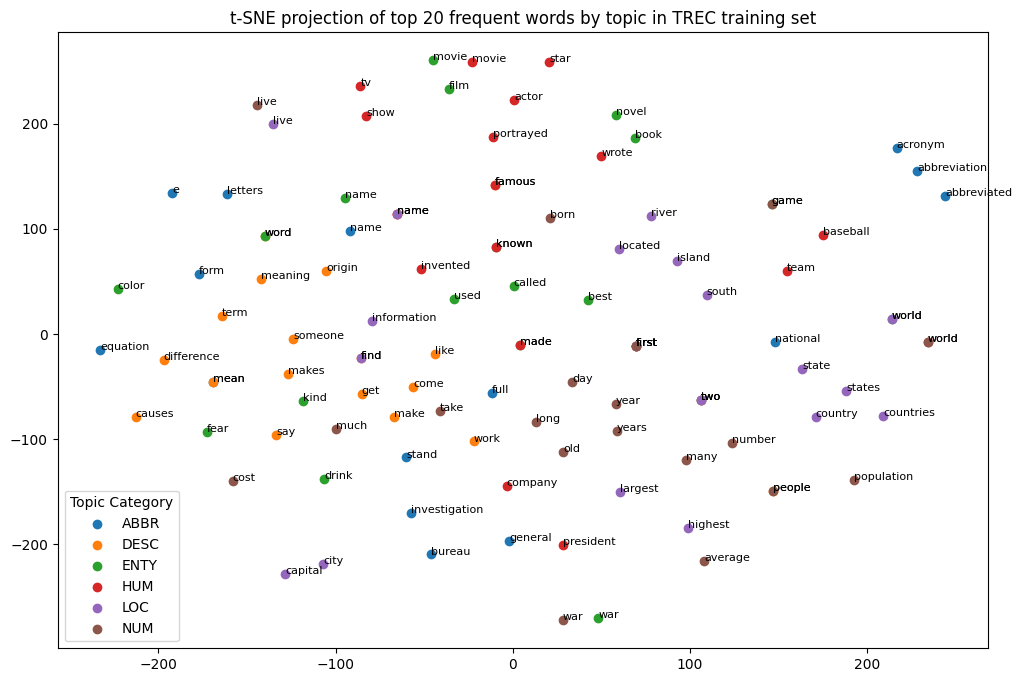

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np
from nltk.corpus import stopwords
import nltk
import torchtext

# Download stopwords if needed
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Collect tokens by topic, remove stopwords, non-alpha tokens
tokens_by_topic = defaultdict(list)
for example in train_data.examples:
    label = example.label
    tokens = example.text
    filtered_tokens = [t.lower() for t in tokens if t.isalpha() and t.lower() not in stop_words]
    tokens_by_topic[label].extend(filtered_tokens)

# Select top 20 frequent words by topic
top_words_by_topic = {}
for topic, tokens in tokens_by_topic.items():
    counter = Counter(tokens)
    top_words_by_topic[topic] = [w for w, _ in counter.most_common(20)]

# Retrieve pretrained embeddings for these words
vectors = TEXT.vocab.vectors
vocab_stoi = TEXT.vocab.stoi

word_vectors = []
labels_for_words = []
words_flat = []

for topic, words in top_words_by_topic.items():
    for word in words:
        idx = vocab_stoi.get(word, -1)
        if idx >= 0:
            vec = vectors[idx].numpy()
            word_vectors.append(vec)
            labels_for_words.append(topic)
            words_flat.append(word)

word_vectors = np.array(word_vectors)

# t-SNE projection to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(word_vectors)

# Plot scatter plot color-coded by topics
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10.colors
unique_topics = sorted(top_words_by_topic.keys())
color_dict = {topic: colors[i % 10] for i, topic in enumerate(unique_topics)}

for topic in unique_topics:
    indices = [i for i, t in enumerate(labels_for_words) if t == topic]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                c=[color_dict[topic]], label=topic)

for i, word in enumerate(words_flat):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(title='Topic Category')
plt.title('t-SNE projection of top 20 frequent words by topic in TREC training set')
plt.show()

# Analysis
Distinct Topic Clusters: Some topic categories (like “LOC” for locations and “HUM” for human/person entities) show partial clustering, indicating that frequent words in these topics are semantically related in the embedding space.

Overlap Between Topics: There is overlap between certain categories, especially between “NUM” (numerical entities), “DESC” (descriptive), and “ENTY” (entities), revealing that these categories share common or semantically similar vocabularies (e.g., “number,” “year,” “name”).

Topic-specific Outliers: Certain words such as “baseball” (NUM), “capital” (LOC), “actor” (HUM) are positioned toward the periphery, suggesting that they have more unique, topic-centric semantic content compared to other frequent words.

Embedding Quality: The visualization demonstrates that GloVe embeddings capture topical and semantic relationships to a large extent; words with similar meanings or roles often emerge closer together regardless of label.

Ambiguity & Polysemy: Some words appear in the vicinity of different clusters or overlap areas (e.g., “mean” in DESC and NUM, “movie” in HUM and ENTY), reflecting ambiguity or multi-topic relevance.

Vocabulary Sharing Across Topics: Frequent generic words (“name,” “meaning,” “state,” “form”) are distributed among various topics, supporting the linguistically expected overlap among question categories.

Dimensionality Reduction Artifacts: t-SNE is nonlinear and can distort true distances, so while relative local clusters are meaningful, global distances should not be overinterpreted.

Label Noise: Some “outliers” may be artifacts of labeling or low sample counts; actual use in downstream classification should consider this.

## Part 2(a)

In [13]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
from itertools import product
import pandas as pd

In [14]:
class SentenceDataset(Dataset):
    def __init__(self, text, label, vocab):
        self.text = text
        self.label = label
        self.vocab = vocab

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        tokens = self.text[idx].split()
        label = self.label[idx]
        indices = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]

        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=TEXT.vocab.stoi['<pad>'])
    labels = torch.stack(labels)
    return texts_padded, labels


In [15]:
train_texts = [" ".join(example.text) for example in train_data.examples]
train_labels = [LABEL.vocab.stoi[example.label] for example in train_data.examples]

valid_texts = [" ".join(example.text) for example in valid_data.examples]
valid_labels = [LABEL.vocab.stoi[example.label] for example in valid_data.examples]

test_texts = [" ".join(example.text) for example in test_data.examples]
test_labels = [LABEL.vocab.stoi[example.label] for example in test_data.examples]

train_dataset = SentenceDataset(train_texts, train_labels, TEXT.vocab.stoi)
valid_dataset = SentenceDataset(valid_texts, valid_labels, TEXT.vocab.stoi)
test_dataset = SentenceDataset(test_texts, test_labels, TEXT.vocab.stoi)

# TO REMOVE sanity check
print(len(train_dataset))
print(len(train_data))

4362
4362


In [16]:
class ClassifierRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, dropout=0.0):
        super(ClassifierRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 6) # 6 possible labels

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1])
        out = self.fc(hidden)
        return out

In [17]:
def train_loop(model, loader, optimizer, criterion, grad_clip=False, max_norm=1.0):
    model.train()
    total_loss, total_correct = 0, 0
    for texts, labels in loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        if grad_clip:
            # print("Clipping") # TO REMOVE sanity check that not clipping when not needed
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct

def eval_loop(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct
    
def test_loop(model, loader):
    model.eval()
    total_correct = 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            total_correct += (outputs.argmax(1) == labels).sum().item()
    
    acc = total_correct / len(loader.dataset)
    return acc

# Early stopper to prevent overfitting, here we use val_acc as the metrics
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = float('-inf')

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc + self.min_delta:
            self.max_validation_acc = validation_acc
            self.counter = 0
        else:
            self.counter += 1
            return self.counter >= self.patience

In [19]:
def training_step(model, train_loader, valid_loader, optimizer, criterion, num_epochs, grad_clip=False, max_norm=1.0):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    early_stopper = EarlyStopper(patience=5, min_delta=0)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_loop(model, train_loader, optimizer, criterion, grad_clip=grad_clip, max_norm=max_norm)
        valid_loss, valid_acc = eval_loop(model, valid_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}:")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
        print(f"Valid loss: {valid_loss:.4f}, Valid acc: {valid_acc:.4f}")

        if early_stopper.early_stop(valid_acc):
            print("Early Stopping Triggered! No Improvements to Validation Accuracy within Patience.")
            no_epochs = epoch+1
            break

        no_epochs = epoch+1

    return train_losses, train_accuracies, valid_losses, valid_accuracies, no_epochs

In [20]:
def find_optimal_hyperparams(param_grid, embedding_matrix):
    best_valid_acc = 0
    best_hyperparams = {}
    results = []

    combinations_list = list(product(*param_grid.values()))

    for params in combinations_list:
        no_epoch, lr, optimizer, batch_size, hidden_dim = params
        hyperparams = dict(zip(param_grid.keys(), params))
        print(f"Training with hyperparameters: {hyperparams}")

        model = ClassifierRNN(embedding_matrix, hidden_dim, dropout=0)
        criterion = nn.CrossEntropyLoss()

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        optimizer = optimizer(model.parameters(), lr=lr, weight_decay=0)

        _, _, _, valid_accuracies, no_epochs = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)

        max_acc = max(valid_accuracies)

        results.append({
            'no_epoch': no_epoch,
            'lr': lr,
            'optimizer': optimizer,
            'batch_size': batch_size,
            'hidden_dim': hidden_dim,
            'best_valid_acc': max(valid_accuracies),
            'epochs ran': no_epochs
        })

        if max_acc > best_valid_acc:
            best_valid_acc = max_acc
            best_hyperparams = {
                'no_epoch': no_epoch,
                'lr': lr,
                'optimizer': optimizer,
                'batch_size': batch_size,
                'hidden_dim': hidden_dim,
            }

    print("Best Hyperparamters: ", best_hyperparams)
    print("Best validation accuracy: ", best_valid_acc)

    return results, best_hyperparams


In [ ]:
param_grid = {
    'no_epochs': [50, 100, 200],
    'lrs': [0.0001, 0.005, 0.001, 0.005],
    'optimizers': [torch.optim.SGD, torch.optim.Adagrad, torch.optim.Adam, torch.optim.RMSprop],
    'batch_sizes': [32, 64, 128],
    'hidden_dims': [64, 128, 256]
}

results, best_hyperparams = find_optimal_hyperparams(param_grid, TEXT.vocab.vectors.numpy())

Training with hyperparameters: {'no_epochs': 50, 'lrs': 0.0001, 'optimizers': <class 'torch.optim.sgd.SGD'>, 'batch_sizes': 32, 'hidden_dims': 64}
Epoch 1:
Train loss: 1.7888, Train acc: 0.1564
Valid loss: 1.7863, Valid acc: 0.1560
Epoch 2:
Train loss: 1.7882, Train acc: 0.1547
Valid loss: 1.7848, Valid acc: 0.1560
Epoch 3:
Train loss: 1.7859, Train acc: 0.1568
Valid loss: 1.7833, Valid acc: 0.1550
Epoch 4:
Train loss: 1.7840, Train acc: 0.1573
Valid loss: 1.7818, Valid acc: 0.1550
Epoch 5:
Train loss: 1.7826, Train acc: 0.1561
Valid loss: 1.7803, Valid acc: 0.1578
Epoch 6:
Train loss: 1.7817, Train acc: 0.1619
Valid loss: 1.7789, Valid acc: 0.1972
Epoch 7:
Train loss: 1.7810, Train acc: 0.1958
Valid loss: 1.7775, Valid acc: 0.2156
Epoch 8:
Train loss: 1.7790, Train acc: 0.2059
Valid loss: 1.7761, Valid acc: 0.2193
Epoch 9:
Train loss: 1.7783, Train acc: 0.2102
Valid loss: 1.7747, Valid acc: 0.2284
Epoch 10:
Train loss: 1.7772, Train acc: 0.2150
Valid loss: 1.7734, Valid acc: 0.2303
Ep

In [19]:
df_results_a = pd.DataFrame(results)
df_results_a = df_results_a.sort_values(by='best_valid_acc', ascending=False)
print(df_results_a)

     no_epoch      lr                                          optimizer  \
308       200  0.0001  Adam (\nParameter Group 0\n    amsgrad: False\...   
307       200  0.0001  Adam (\nParameter Group 0\n    amsgrad: False\...   
32         50  0.0001  RMSprop (\nParameter Group 0\n    alpha: 0.99\...   
311       200  0.0001  Adam (\nParameter Group 0\n    amsgrad: False\...   
20         50  0.0001  Adam (\nParameter Group 0\n    amsgrad: False\...   
..        ...     ...                                                ...   
152       100  0.0001  SGD (\nParameter Group 0\n    dampening: 0\n  ...   
223       100  0.0010  SGD (\nParameter Group 0\n    dampening: 0\n  ...   
3          50  0.0001  SGD (\nParameter Group 0\n    dampening: 0\n  ...   
292       200  0.0001  SGD (\nParameter Group 0\n    dampening: 0\n  ...   
78         50  0.0010  SGD (\nParameter Group 0\n    dampening: 0\n  ...   

     batch_size  hidden_dim  best_valid_acc  
308          32         256        0.8110

## Part 2(b)

In [ ]:
# Set ideal hyperparameters from above
no_epoch = best_hyperparams["no_epoch"]
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]

best_reg_technique = []

# Define a function for Regularisation Tests
def regularisation_test(weight_decay, dropout, grad_clip, max_norm, reg_technique):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialise model
    model = ClassifierRNN(TEXT.vocab.vectors.numpy() , hidden_dim, dropout=dropout)

    # Initialise optimiser with L2 regularization
    optimizer = optimizer.__class__(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    if grad_clip == True:
        _, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch, grad_clip=True, max_norm=max_norm)
    else:
        _, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)

    test_acc = test_loop(model, test_loader)
    print(f"Test Accuracy {reg_technique} (Dropout: {dropout}, Weight Decay: {weight_decay}, Max Norm: {max_norm}): {test_acc:.4f}")

    return {
        'technique': reg_technique,
        'dropout': dropout,
        'weight_decay': weight_decay,
        'grad_clip': grad_clip,
        'max_norm': max_norm,
        'best_val_acc': max(valid_accuracies),
        'test_acc': test_acc
    }

Regularization - Baseline

In [21]:
best_reg_technique.append(regularisation_test(weight_decay=0.0,dropout=0.0, grad_clip=False, max_norm=0.0, reg_technique="Baseline"))

Epoch 1:
Train loss: 1.6806, Train acc: 0.2288
Valid loss: 1.6564, Valid acc: 0.2422
Epoch 2:
Train loss: 1.6499, Train acc: 0.2297
Valid loss: 1.6437, Valid acc: 0.2532
Epoch 3:
Train loss: 1.6483, Train acc: 0.2297
Valid loss: 1.6473, Valid acc: 0.2505
Epoch 4:
Train loss: 1.6474, Train acc: 0.2419
Valid loss: 1.6676, Valid acc: 0.2046
Epoch 5:
Train loss: 1.6426, Train acc: 0.2485
Valid loss: 1.6405, Valid acc: 0.2761
Epoch 6:
Train loss: 1.5270, Train acc: 0.3508
Valid loss: 1.4753, Valid acc: 0.3807
Epoch 7:
Train loss: 1.3672, Train acc: 0.4177
Valid loss: 1.3117, Valid acc: 0.4450
Epoch 8:
Train loss: 1.2685, Train acc: 0.4535
Valid loss: 1.2488, Valid acc: 0.4890
Epoch 9:
Train loss: 1.1781, Train acc: 0.4991
Valid loss: 1.1940, Valid acc: 0.5294
Epoch 10:
Train loss: 1.1030, Train acc: 0.5456
Valid loss: 1.1507, Valid acc: 0.5422
Epoch 11:
Train loss: 1.0153, Train acc: 0.6004
Valid loss: 1.0760, Valid acc: 0.5440
Epoch 12:
Train loss: 0.9507, Train acc: 0.6337
Valid loss: 1.0

Regularization - L2

In [22]:
weight_decay = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
for weight_decay in weight_decay:
    print(f"Testing L2 Regularization with weight decay: {weight_decay}")
    best_reg_technique.append(regularisation_test(weight_decay=weight_decay,dropout=0.0, grad_clip=False, max_norm=0.0, reg_technique="L2 Regularization"))

Testing L2 Regularization with weight decay: 1e-05
Epoch 1:
Train loss: 1.6865, Train acc: 0.2263
Valid loss: 1.6445, Valid acc: 0.2486
Epoch 2:
Train loss: 1.6476, Train acc: 0.2299
Valid loss: 1.6494, Valid acc: 0.2046
Epoch 3:
Train loss: 1.6456, Train acc: 0.2283
Valid loss: 1.6445, Valid acc: 0.2752
Epoch 4:
Train loss: 1.6445, Train acc: 0.2382
Valid loss: 1.6470, Valid acc: 0.2495
Epoch 5:
Train loss: 1.5792, Train acc: 0.3106
Valid loss: 1.5263, Valid acc: 0.3716
Epoch 6:
Train loss: 1.4252, Train acc: 0.4007
Valid loss: 1.4279, Valid acc: 0.4257
Epoch 7:
Train loss: 1.3458, Train acc: 0.4289
Valid loss: 1.3161, Valid acc: 0.4394
Epoch 8:
Train loss: 1.2190, Train acc: 0.4828
Valid loss: 1.2081, Valid acc: 0.5037
Epoch 9:
Train loss: 1.1397, Train acc: 0.5429
Valid loss: 1.2256, Valid acc: 0.5560
Epoch 10:
Train loss: 1.0690, Train acc: 0.5688
Valid loss: 1.0825, Valid acc: 0.5927
Epoch 11:
Train loss: 1.0042, Train acc: 0.6096
Valid loss: 1.0722, Valid acc: 0.6092
Epoch 12:
Tr

Regularization - Dropout

In [23]:
dropout = [0.2, 0.3, 0.4]
for dropout in dropout:
    print(f"Testing Dropout: {dropout}")
    best_reg_technique.append(regularisation_test(weight_decay=0.0,dropout=dropout, grad_clip=False, max_norm=0.0, reg_technique="Dropout"))

Testing Dropout: 0.2
Epoch 1:
Train loss: 1.6944, Train acc: 0.2150
Valid loss: 1.6557, Valid acc: 0.2046
Epoch 2:
Train loss: 1.6540, Train acc: 0.2320
Valid loss: 1.6513, Valid acc: 0.2477
Epoch 3:
Train loss: 1.6483, Train acc: 0.2331
Valid loss: 1.6667, Valid acc: 0.2495
Epoch 4:
Train loss: 1.6484, Train acc: 0.2370
Valid loss: 1.6620, Valid acc: 0.2174
Epoch 5:
Train loss: 1.5638, Train acc: 0.3210
Valid loss: 1.4669, Valid acc: 0.4037
Epoch 6:
Train loss: 1.3936, Train acc: 0.4145
Valid loss: 1.3635, Valid acc: 0.4440
Epoch 7:
Train loss: 1.3025, Train acc: 0.4496
Valid loss: 1.3466, Valid acc: 0.4349
Epoch 8:
Train loss: 1.1983, Train acc: 0.4906
Valid loss: 1.2445, Valid acc: 0.5119
Epoch 9:
Train loss: 1.1400, Train acc: 0.5144
Valid loss: 1.1832, Valid acc: 0.5697
Epoch 10:
Train loss: 1.1138, Train acc: 0.5484
Valid loss: 1.0897, Valid acc: 0.5761
Epoch 11:
Train loss: 1.0152, Train acc: 0.6004
Valid loss: 1.0277, Valid acc: 0.6193
Epoch 12:
Train loss: 0.9517, Train acc: 0

Regularization - Gradient Clipping

In [24]:
max_norm = [0.1, 0.5, 1.0]
for max_norm in max_norm:
    print(f"Testing Gradient Clipping with Value: {max_norm}")
    best_reg_technique.append(regularisation_test(weight_decay=0.0,dropout=0.0, grad_clip=True, max_norm=max_norm, reg_technique="Gradient Clipping"))

Testing Gradient Clipping with Value: 0.1
Epoch 1:
Train loss: 1.6824, Train acc: 0.2276
Valid loss: 1.6492, Valid acc: 0.2046
Epoch 2:
Train loss: 1.6480, Train acc: 0.2304
Valid loss: 1.6487, Valid acc: 0.2495
Epoch 3:
Train loss: 1.6453, Train acc: 0.2476
Valid loss: 1.6449, Valid acc: 0.2679
Epoch 4:
Train loss: 1.5544, Train acc: 0.3391
Valid loss: 1.4954, Valid acc: 0.3761
Epoch 5:
Train loss: 1.3988, Train acc: 0.4115
Valid loss: 1.4159, Valid acc: 0.3872
Epoch 6:
Train loss: 1.2696, Train acc: 0.4601
Valid loss: 1.3766, Valid acc: 0.4376
Epoch 7:
Train loss: 1.1809, Train acc: 0.5222
Valid loss: 1.1887, Valid acc: 0.5294
Epoch 8:
Train loss: 1.1011, Train acc: 0.5722
Valid loss: 1.1015, Valid acc: 0.5991
Epoch 9:
Train loss: 1.0340, Train acc: 0.6004
Valid loss: 1.0907, Valid acc: 0.5936
Epoch 10:
Train loss: 0.9699, Train acc: 0.6325
Valid loss: 1.0092, Valid acc: 0.6183
Epoch 11:
Train loss: 0.9091, Train acc: 0.6520
Valid loss: 1.0244, Valid acc: 0.6275
Epoch 12:
Train loss:

In [25]:
# TO CLEAN
cols = ['technique', 'dropout', 'weight_decay', 'grad_clip', 'max_norm', 'best_val_acc', 'test_acc']

df_best_reg_technique = pd.DataFrame(best_reg_technique)

df_best_reg_technique.loc[~df_best_reg_technique['grad_clip'], 'max_norm'] = pd.NA # Hde max_norm when grad clipping isn't used
df_best_reg_technique = df_best_reg_technique[cols]

df_best_reg_technique['best_val_acc'] = df_best_reg_technique['best_val_acc'].round(4)
df_best_reg_technique['test_acc'] = df_best_reg_technique['test_acc'].round(4)

# Find best parameters per technique
df_best_reg_technique = (
    df_best_reg_technique.sort_values('test_acc', ascending=False)
      .groupby('technique', as_index=False, sort=False)
      .head(1)
      .reset_index(drop=True)
)

print("Best run per technique:")
print(df_best_reg_technique.to_string(index=False))

Best run per technique:
        technique  dropout  weight_decay  grad_clip  max_norm  best_val_acc  test_acc
Gradient Clipping      0.0       0.00000       True       0.1        0.8202     0.842
L2 Regularization      0.0       0.00001      False       NaN        0.7945     0.836
          Dropout      0.3       0.00000      False       NaN        0.8009     0.830
         Baseline      0.0       0.00000      False       NaN        0.6716     0.688


Regularization - ALL Techniques (Best Combination)

In [26]:
# TO CLEAN
def _get_row(df, pattern):
    m = df['technique'].str.contains(pattern, case=False, regex=True)
    return df[m].iloc[0] if m.any() else None

row_dropout = _get_row(df_best_reg_technique, r'\bdropout\b')
row_clip    = _get_row(df_best_reg_technique, r'(grad|clip)')
row_l2      = _get_row(df_best_reg_technique, r'(l2|regularization)')

best_dropout      = float(row_dropout['dropout']) if row_dropout is not None else 0.0
best_weight_decay = float(row_l2['weight_decay']) if row_l2 is not None else 0.0
if row_clip is not None:
    best_grad_clip = True
    best_max_norm  = float(row_clip['max_norm']) if pd.notna(row_clip['max_norm']) else 1.0
else:
    best_grad_clip = False
    best_max_norm  = 1.0  # default if you need it later

print("Best per technique (inferred):")
print(f"- Dropout: {best_dropout}")
print(f"- GradClip: {best_grad_clip} (max_norm={best_max_norm})")
print(f"- L2 weight_decay: {best_weight_decay}")


combos = [
    ("Dropout + GradClip",            best_weight_decay if 0 else 0.0, best_dropout, True,  best_max_norm),
    ("GradClip + L2",                 best_weight_decay,                0.0,          True,  best_max_norm),
    ("Dropout + L2",                  best_weight_decay,                best_dropout,  False, 0.0),
    ("All (Dropout+GradClip+L2)",     best_weight_decay,                best_dropout,  True,  best_max_norm),
]

for name, wd, dp, use_clip, mn in combos:
    res = regularisation_test(
        weight_decay=wd,
        dropout=dp,
        grad_clip=use_clip,
        max_norm=mn,
        reg_technique=name
    )
    best_reg_technique.append(res)

# --- 3) Build & print the final DataFrame (including the new combo runs) ---
df_all = pd.DataFrame(best_reg_technique)

# Hide max_norm if grad_clip is False for nicer display
if 'grad_clip' in df_all.columns:
    df_all.loc[~df_all['grad_clip'], 'max_norm'] = pd.NA

col_order = ['technique', 'dropout', 'weight_decay', 'grad_clip', 'max_norm', 'best_val_acc', 'test_acc']
df_all = df_all[[c for c in col_order if c in df_all.columns]]

for c in ['best_val_acc', 'test_acc']:
    if c in df_all.columns:
        df_all[c] = df_all[c].astype(float).round(4)

print("\nAll runs (singles + combinations) sorted by test_acc:")
print(df_all.sort_values('test_acc', ascending=False).to_string(index=False))

Best per technique (inferred):
- Dropout: 0.3
- GradClip: True (max_norm=0.1)
- L2 weight_decay: 1e-05


/var/folders/89/0j8bcxc15h5cb6d54l8g1nyh0000gn/T/ipykernel_39946/3911384865.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m = df['technique'].str.contains(pattern, case=False, regex=True)


Epoch 1:
Train loss: 1.6962, Train acc: 0.2251
Valid loss: 1.6527, Valid acc: 0.2046
Epoch 2:
Train loss: 1.6534, Train acc: 0.2361
Valid loss: 1.6484, Valid acc: 0.2046
Epoch 3:
Train loss: 1.6519, Train acc: 0.2382
Valid loss: 1.6430, Valid acc: 0.2661
Epoch 4:
Train loss: 1.6409, Train acc: 0.2467
Valid loss: 1.6255, Valid acc: 0.2761
Epoch 5:
Train loss: 1.4927, Train acc: 0.3751
Valid loss: 1.4301, Valid acc: 0.3972
Epoch 6:
Train loss: 1.3522, Train acc: 0.4099
Valid loss: 1.3132, Valid acc: 0.4550
Epoch 7:
Train loss: 1.2511, Train acc: 0.4574
Valid loss: 1.2326, Valid acc: 0.5147
Epoch 8:
Train loss: 1.1577, Train acc: 0.5105
Valid loss: 1.2372, Valid acc: 0.4936
Epoch 9:
Train loss: 1.1136, Train acc: 0.5271
Valid loss: 1.2042, Valid acc: 0.5193
Epoch 10:
Train loss: 1.0489, Train acc: 0.5702
Valid loss: 1.0790, Valid acc: 0.6018
Epoch 11:
Train loss: 1.0041, Train acc: 0.5986
Valid loss: 1.1073, Valid acc: 0.5807
Epoch 12:
Train loss: 0.9405, Train acc: 0.6348
Valid loss: 1.0

## Part 2(c)

In [ ]:
no_epoch = best_hyperparams["no_epoch"]
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]




NameError: name 'train_losses' is not defined

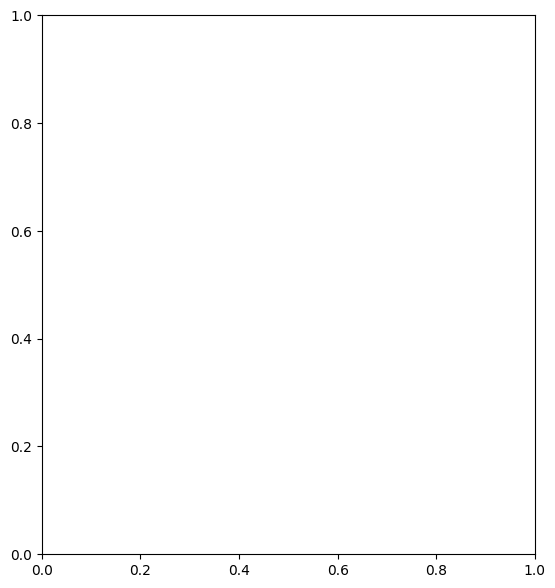

In [27]:
plt.figure(figsize=(14, 7))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss vs Epochs')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()